* 整理自： https://gymnasium.farama.org/tutorials/gymnasium_basics/vector_envs_tutorial/#sphx-glr-tutorials-gymnasium-basics-vector-envs-tutorial-py

如何使用矢量化环境来训练 Advantage Actor-Critic 代理。

* 矢量化环境[3]可以通过允许相同环境的多个实例并行运行(在多个 CPUs 上)来帮助实现更快、更健壮的训练。这可以显著减少方差，从而加快训练速度。


我们将从头开始实现一个 Advantage Actor-Critic，你将学到如何将**批处理的状态**馈送到你的网络中，以获得行动向量(每个环境一个行动)，并计算 actor 和 critic 在小批量 transitions 上的损失。

每个 minibatch 包含一个采样阶段的 transitions ：n_step_per_update 个 step 在 n_envs 个环境中并行执行
(将两者相乘以获得 minibatch 中的 transitions 数量)。
* the number of transitions in a minibatch = n_steps_per_update $\times$ n_envs

在每个采样阶段后，计算损耗并执行一个梯度步骤。

为了计算优势，我们将使用广义优势估计(Generalized Advantage Estimation, GAE)方法[2]，该方法平衡了优势估计的**方差和偏差**之间的**权衡**。




为了计算优势 advantages，我们将使用广义优势估计(GAE)方法[2]，该方法平衡了优势估计的**方差和偏差**之间的权衡。


A2C 代理类是用输入状态的特征数量、代理可以采取的动作数量、学习率和并行运行以收集经验的环境数量来初始化的。

定义了 actor 和 critic 网络，并初始化了各自的优化器。

网络的前向传递**接受**状态的批处理向量，并**返回**状态值张量和动作逻辑logits 张量。

select_action 方法返回所选操作的元组，这些操作的 log-probs 以及每个操作的状态值。
此外，它还返回策略分布的熵，该熵从稍后的损失中减去(带有权重因子 ent_coef)以鼓励探索。

get_losses 函数计算 actor 和 critic 网络的损失(使用 GAE)，然后使用 update_parameters 函数更新这些损失。


In [1]:
pip install gymnasium

In [2]:
# 库函数 导入

from __future__ import annotations

import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch import optim

from tqdm import tqdm

import gymnasium as gym

## Advantage Actor-Critic (A2C)

Actor-Critic 组合了基于价值和基于策略的方法的元素。

在 A2C 中，代理有两个独立的神经网络:一个评估状态值函数的批评家网络，和一个输出所有动作的分类概率分布的行为者网络。批评家网络被训练成最小化预测状态值和代理接收到的实际回报之间的均方误差(这相当于最小化平方优势，因为一个行为的优势是回报和状态值之间的差:A(s, A) = Q(s, A) - V(s)。行动者网络经过训练，通过根据评论家网络选择具有高期望值的行为来最大化预期回报。




本教程的重点不在于 A2C 本身的细节。相反，本教程将侧重于如何使用**矢量化环境**和**领域随机化**来**加速** A2C (和其他强化学习算法)的**训练**过程。


In [3]:
class A2C(nn.Module):
  """
  (Synchronous) Advantage Actor-Critic (A2C) 代理 类

  参数：
    n_features: 输入状态 的 特征数目
    n_actions: agent 能采取的动作 数目
    device:  运行计算的设备 (在 GPU 上运行 对于更大的神经网络来说可能更快，
          对于这段代码，CPU 完全没问题)。
    critic_lr: critic 网络的学习率。 一般比  actor_lr 大一些
    actor_lr: actor 网络的学习率
    n_envs:  为收集经验而 并行运行(在多个 cpu 上) 的 环境数量。
  """

  def __init__(
      self,
      n_features: int,
      n_actions: int,
      device: torch.device,
      critic_lr: float,
      actor_lr: float,
      n_envs: int,
  ) -> None:
    """初始化 actor 和 critic 网络 及其 各自的优化器。"""
    super().__init__()
    self.device = device
    self.n_envs = n_envs

    critic_layers = [
        nn.Linear(n_features, 32),
        nn.ReLU(),
        nn.Linear(32, 32),
        nn.ReLU(),
        nn.Linear(32, 1),
    ] # 估计 V(s)

    actor_layers = [
        nn.Linear(n_features, 32),
        nn.ReLU(),
        nn.Linear(32, 32),
        nn.ReLU(),
        nn.Linear(32, n_actions),
    ] #  估计动作 logits (稍后将输入到 softmax 中)

    # 为什么 π 要 取 log ，这是必要的吗

    # 定义 actor 和 crictic 网络
    self.critic = nn.Sequential(*critic_layers).to(self.device)
    self.actor = nn.Sequential(*actor_layers).to(self.device)

    # 为 actor 和 critic 定义 优化器
    self.critic_optim = optim.RMSprop(self.critic.parameters(), lr=critic_lr)
    self.actor_optim = optim.RMSprop(self.actor.parameters(), lr=actor_lr)

  def forward(self, x: np.ndarray)-> tuple[torch.Tensor, torch.Tensor]:
    """
    网络的 前向计算

    参数：
      x: 状态的 批次向量 A batched vector of states.

    返回：
      state_values: A tensor with the state values, with shape [n_envs,].
      action_logits_vec: A tensor with the action logits, with shape [n_envs, n_actions].
    """
    x = torch.Tensor(x).to(self.device)
    state_values = self.critic(x)  # shape: [n_envs,]
    action_logits_vec = self.actor(x) # shape: [n_envs, n_actions]
    return (state_values, action_logits_vec)


  def select_action(self, x:np.ndarray) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    返回所选动作的元组以及这些动作的 log-probs

    参数：
      x: A batched vector of states.

    返回值： 动作、动作的 log 概率、状态值
      actions: A tensor with the actions, with shape [n_steps_per_update, n_envs].
      action_log_probs: A tensor with the log-probs of the actions, with shape [n_steps_per_update, n_envs].
      state_values: A tensor with the state values, with shape [n_steps_per_update, n_envs].
    """
    state_values, action_logits = self.forward(x)
    action_pd = torch.distributions.Categorical(logits=action_logits) # 隐式使用softmax
    actions = action_pd.sample()
    action_log_probs = action_pd.log_prob(actions)
    entropy = action_pd.entropy()
    return (actions, action_log_probs, state_values, entropy)

  def get_losses(
      self,
      rewards: torch.Tensor,
      action_log_probs: torch.Tensor,
      value_preds: torch.Tensor,
      entropy: torch.Tensor,
      masks: torch.Tensor,
      gamma: float,
      lam: float,
      ent_coef: float,
      device: torch.device
  )->tuple[torch.Tensor, torch.Tensor]:
    """
    计算 critic 和 actor 的 minibatch (一个采样阶段搜集的 transitions) 的损失
    Generalized Advantage Estimation (GAE) 计算优势 (https://arxiv.org/abs/1506.02438)

    参数：奖励、动作 log 概率、预测的状态值、n 步内奖励记录 masks[step]、
      rewards: A tensor with the rewards for each time step in the episode, with shape [n_steps_per_update, n_envs].
      action_log_probs: A tensor with the log-probs of the actions taken at each time step in the episode, with shape [n_steps_per_update, n_envs].
      value_preds: A tensor with the state value predictions for each time step in the episode, with shape [n_steps_per_update, n_envs].
      masks: masks[step] 环境正在执行 为 1， 若是终止则为 0. A tensor with the masks for each time step in the episode, with shape [n_steps_per_update, n_envs].
      gamma: The discount factor.
      lam: The GAE hyperparameter. (lam=1 corresponds to Monte-Carlo sampling with high variance and no bias,
                                    and lam=0 corresponds to normal TD-Learning that has a low variance but is biased
                                    because the estimates are generated by a Neural Net).
      device: The device to run the computations on (e.g. CPU or GPU).

    返回： critic_loss 和 actor_loss
      critic_loss: The critic loss for the minibatch.
      actor_loss: The actor loss for the minibatch.
    """
    T = len(rewards)
    advantages = torch.zeros(T, self.n_envs, device=device)

    # 计算 GAE 版本的 advantage
    gae = 0.0
    for t in reversed(range(T-1)):
      td_error = (
          rewards[t] + gamma * masks[t] * value_preds[t + 1]-value_preds[t]
      )
      gae = td_error + gamma * lam * masks[t] * gae
      advantages[t] = gae

    # 计算 actor 和 critic 的 minibatch 的 loss
    critic_loss = advantages.pow(2).mean()

    # 当熵增加时，给予奖励， 以鼓励 探索
    actor_loss = (
        -(advantages.detach() * action_log_probs).mean() - ent_coef * entropy.mean()
    )
    return (critic_loss, actor_loss)

  def update_parameters(
      self, critic_loss: torch.Tensor, actor_loss: torch.Tensor
  ) -> None:
    """
    更新 actor 和 critic 网络的 参数

    参数：
      critic_loss: The critic loss.
      actor_loss: The actor loss.
    """
    self.critic_optim.zero_grad()
    critic_loss.backward()
    self.critic_optim.step()

    self.actor_optim.zero_grad()
    actor_loss.backward()
    self.actor_optim.step()



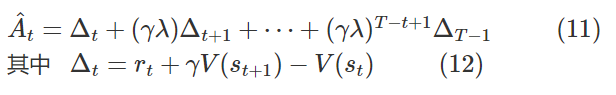

## 使用矢量化环境

当你计算两个神经网络在一个epoch上的损失时，它可能有**很高的方差**。

在矢量化的环境中，我们可以并行地处理  n_envs，从而获得线性加速(这意味着理论上，我们收集样本的速度要快 n_envs 倍)，我们可以用它来计算当前策略和 critic 网络的损失。

当我们使用**更多的样本**来计算损失时，它将具有**更低的方差**，因此可以**更快地学习**。

A2C 是一种同步方法，这意味着网络的参数更新是确定的(在每个采样阶段之后)，但我们仍然可以使用异步矢量 envs 来生成多个进程以并行环境执行。

创建矢量环境最简单的方法是调用 `gym.vector.make`，它创建同一环境的多个实例:

```
envs = gym.vector.make("LunarLander-v2", num_envs=3, max_episode_steps=600)
```





## 域随机化

如果我们想要随机化训练环境以获得更健壮的代理(可以处理环境的不同参数化，因此可能具有更高的泛化程度)，我们可以手动设置所需的参数或使用伪随机数生成器来生成它们。




In [4]:
!apt update
!apt install python-opengl xvfb -y
!pip install -q swig
!pip install box2d==2.3.2 gym[box2d]==0.25.2 box2d-py pyvirtualdisplay tqdm numpy==1.22.4
!pip install box2d==2.3.2 box2d-kengz

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Ign:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://r2u.stat.illinois.edu/ubuntu jammy Release
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
136 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: Skipping acquire of configured file 'main/source/Sources' as

In [5]:
!pip install gymnasium[box2d]

  Using cached pygame-2.6.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
Using cached pygame-2.6.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (14.0 MB)
  Attempting uninstall: pygame
    Found existing installation: pygame 2.1.0
    Uninstalling pygame-2.1.0:
      Successfully uninstalled pygame-2.1.0


In [6]:
# 手动设置 3 个具有不同参数的平行“LunarLander-v2”envs:

envs = gym.vector.AsyncVectorEnv(
    [
        lambda: gym.make(
            "LunarLander-v2",
            gravity=-10.0,
            enable_wind=True,
            wind_power=15.0,
            turbulence_power=1.5,
            max_episode_steps=600,
        ),
        lambda: gym.make(
            "LunarLander-v2",
            gravity=-9.8,
            enable_wind=True,
            wind_power=10.0,
            turbulence_power=1.3,
            max_episode_steps=600,
        ),
        lambda: gym.make(
            "LunarLander-v2",
            gravity=-7.0,
            enable_wind=False,
            max_episode_steps=600
        )
    ]
)

In [7]:
# 随机生成 3 个并行的“LunarLander-v2”envs 的参数。通过 np.clip 保持在推荐的参数空间中:
# numpy.clip(a, a_min, a_max, out=None, **kwargs) # 将数组 a 中的元素， 相应位置 小于 a_min, 置为 a_min。 大于 a_max, 置为 a_max
# random.normal(loc=0.0, scale=1.0, size=None) # 均值， 方差

envs = gym.vector.AsyncVectorEnv(
    [
        lambda: gym.make(
            "LunarLander-v2",
            gravity=np.clip(
                np.random.normal(loc=-10.0, scale=1.0),a_min=-11.99, a_max=-0.01
            ),
            enable_wind=np.random.choice([True, False]),
            wind_power=np.clip(
                np.random.normal(loc=15.0, scale=1.0), a_min=0.01, a_max=19.99
            ),
            turbulence_power=np.clip(
               np.random.normal(loc=1.5, scale=0.5), a_min=0.01, a_max=1.99
            ),
            max_episode_steps=600,
        )
        for i in range(3)
    ]
)

这里我们使用正态分布，环境的**标准参数**化作为平均值和任意标准偏差(尺度)。根据问题的不同，您可以尝试更高的方差并使用不同的分布。


如果您在整个训练时间内都在 n_envs 个相同环境上进行训练，并且 n_envs 是一个相对较低的数字(与环境的复杂程度成比例)，那么您选择的特定参数化仍有可能会过拟合。

为了缓解这种情况，你可以选择大量随机参数化的环境，或者每隔几个采样阶段重新构建环境，以生成一组新的伪随机参数。



## Setup

In [8]:
# 环境 超参数

n_envs = 10
n_updates = 1000
n_steps_per_update = 128
randomize_domain = False

# agent 超参数

gamma = 0.999
lam = 0.95  # GAE 的超参数
ent_coef = 0.01 # #熵奖励系数(鼓励探索)
actor_lr = 0.001 # actor 的 学习率 更低，以便 目标更稳定，对于 critic 更容易评估
critic_lr = 0.005

# 环境设置
if randomize_domain:
  envs = gym.vector.AsyncVectorEnv(
      [
          lambda: gym.make(
              "LunarLander-v2",
              gravity=np.clip(
                  np.random.normal(loc=-10.0, scale=1.0),a_min=-11.99, a_max=-0.01
              ),
              enable_wind=np.random.choice([True, False]),
              wind_power=np.clip(
                  np.random.normal(loc=15.0, scale=1.0), a_min=0.01, a_max=19.99
              ),
              turbulence_power=np.clip(
                np.random.normal(loc=1.5, scale=0.5), a_min=0.01, a_max=1.99
              ),
              max_episode_steps=600,
          )
          for i in range(n_envs)
      ]
  )
else:
  envs = gym.vector.make("LunarLander-v2", num_envs=n_envs, max_episode_steps=600)


obs_shape = envs.single_observation_space.shape[0]
action_shape = envs.single_action_space.n

# device 配置
use_cuda = False
if use_cuda:
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
else:
  device = torch.device("cpu")

# 初始化
agent = A2C(obs_shape, action_shape, device, critic_lr, actor_lr, n_envs)


/usr/local/lib/python3.10/dist-packages/gymnasium/vector/__init__.py:53: UserWarning: WARN: `gymnasium.vector.make(...)` is deprecated and will be replaced by `gymnasium.make_vec(...)` in v1.0
  gym.logger.warn(


## 训练 A2C agent

对于我们的训练循环，我们使用 `RecordEpisodeStatistics` wrapper 来记录回合episode长度和回报returns，并且我们还保存损失和熵，以便在代理完成训练后绘制它们。



In [9]:
# 创建一个 wrapper 环境 来 存储 回合episode 奖励 和 回合长度

envs_wrapper = gym.wrappers.RecordEpisodeStatistics(envs, deque_size=n_envs * n_updates)

critic_losses = []
actor_losses = []
entropies = []

# 用 tqdm 来绘制 训练进度条
for sample_phase in tqdm(range(n_updates)):
  # 无需重置环境。 等到 回合终止时会 自动重置

  # 重置用于 收集 一个回合经验的 列表 (抽样阶段)
  ep_value_preds = torch.zeros(n_steps_per_update, n_envs, device=device)
  ep_rewards = torch.zeros(n_steps_per_update, n_envs, device=device)
  ep_action_log_probs = torch.zeros(n_steps_per_update, n_envs, device=device)
  masks = torch.zeros(n_steps_per_update, n_envs, device=device)

  # 在 训练开始时，重置所有的环境以获得初始状态
  if sample_phase == 0:
    states, info = envs_wrapper.reset(seed=42)

  # 在 并行环境中 走一步 以 收集数据
  for step in range(n_steps_per_update):
    # 根据 agent 的状态 S_{t} 选择一个 动作 A_{t}
    actions, action_log_probs, state_value_preds, entropy = agent.select_action(
        states
    )

    # 在 环境中 执行 动作 A_{t} 得到 S_{t+1} 和 R_{t+1}
    states, rewards, terminated, truncated, infos = envs_wrapper.step(
        actions.cpu().numpy()
    )

    ep_value_preds[step] = torch.squeeze(state_value_preds)
    ep_rewards[step] = torch.tensor(rewards, device=device)
    ep_action_log_probs[step] = action_log_probs

    # 增加 一个 mask (用于 后续的 累积回报)
    # 对于每个 env， 如果 回合在进行中， mask 为 1， 若终止则为 0 【非截断情形】
    masks[step] = torch.tensor([not term for term in terminated])

  # 累积 actor 和 critic 的 losses
    critic_loss, actor_loss = agent.get_losses(
      ep_rewards,
      ep_action_log_probs,
      ep_value_preds,
      entropy,
      masks,
      gamma,
      lam,
      ent_coef,
      device
  )

  # 更新 actor 和 critic 网络
  agent.update_parameters(critic_loss, actor_loss)

  # 记录 losses 和 entropy
  critic_losses.append(critic_loss.detach().cpu().numpy())
  actor_losses.append(actor_loss.detach().cpu().numpy())
  entropies.append(entropy.detach().mean().cpu().numpy())


100%|██████████| 1000/1000 [43:11<00:00,  2.59s/it]


## 绘图

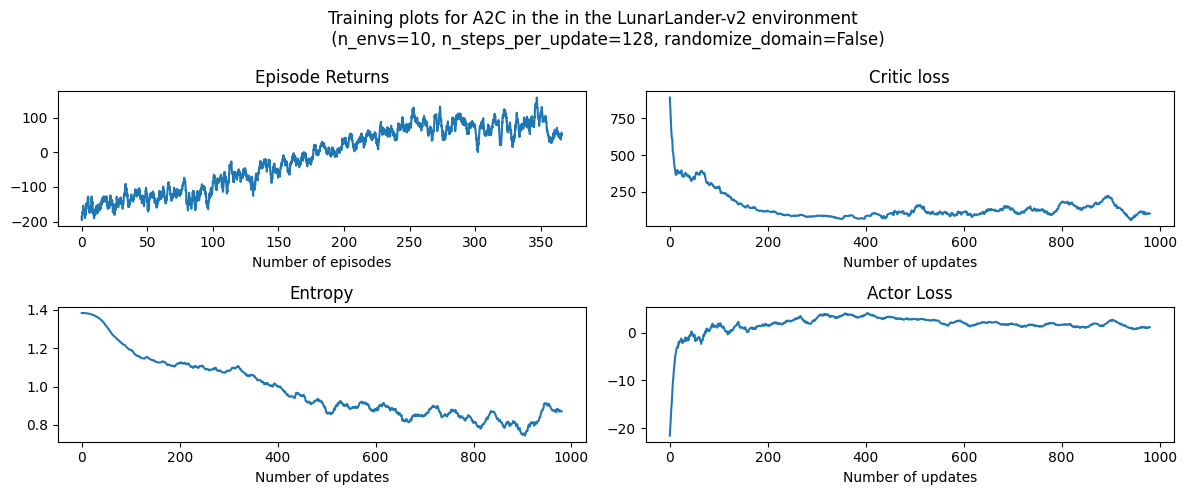

In [10]:
# 绘制 结果

# %matplotlib inline

rolling_length = 20  # 平滑 用于 可视化
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 5))
fig.suptitle(
    f"Training plots for {agent.__class__.__name__} in the in the LunarLander-v2 environment \n \
    (n_envs={n_envs}, n_steps_per_update={n_steps_per_update}, randomize_domain={randomize_domain})"
)

# 回合 回报
axs[0][0].set_title("Episode Returns")
episode_returns_moving_average = (
    np.convolve(
      np.array(envs_wrapper.return_queue).flatten(),
      np.ones(rolling_length),
      mode="valid",
    )/ rolling_length
)

axs[0][0].plot(
  np.arange(len(episode_returns_moving_average)) / n_envs,
  episode_returns_moving_average,
)
axs[0][0].set_xlabel("Number of episodes")


# 熵 entropy
axs[1][0].set_title("Entropy")
entropy_moving_average = (
    np.convolve(np.array(entropies), np.ones(rolling_length),mode="valid"
                )/rolling_length
)
axs[1][0].plot(entropy_moving_average)
axs[1][0].set_xlabel("Number of updates")


# critic loss
axs[0][1].set_title("Critic loss")
critic_losses_moving_average = (
    np.convolve(
        np.array(critic_losses).flatten(), np.ones(rolling_length), mode="valid"
    ) / rolling_length
)
axs[0][1].plot(critic_losses_moving_average)
axs[0][1].set_xlabel("Number of updates")

# actor loss
axs[1][1].set_title("Actor Loss")
actor_losses_moving_average = (
    np.convolve(np.array(actor_losses).flatten(), np.ones(rolling_length), mode="valid"
    ) / rolling_length
)
axs[1][1].plot(actor_losses_moving_average)
axs[1][1].set_xlabel("Number of updates")

plt.tight_layout()
plt.show()


## 存储 和 加载 权重



In [11]:
save_weights =  False
load_weights = False

actor_weights_path = "weights/actor_weights.h5"
critic_weights_path = "weights/critic_weights.h5"

if not os.path.exists("weights"):
  os.mkdir("weights")

# 存储 网络权重
if save_weights:
  torch.save(agent.actor.state_dict(), actor_weights_path)
  torch.save(agent.critic.state_dict(),critic_weights_path)

# 加载 网络权重
if load_weights:
  agent = A2C(obs_shape, action_shape, device, critic_lr, actor_lr)

  agent.actor.load_state_dict(torch.load(actor_weights_path))
  agent.critic.load_state_dict(torch.load(critic_weights_path))
  agent.actor.eval()
  agent.critic.eval()


## Agent 可视化


In [12]:
# 可视化 几个 回合

n_showcase_episodes = 3

for episode in range(n_showcase_episodes):
  print(f"starting episode {episode}...")

  # 创建一个新的示例环境来获取新的随机参数
  if randomize_domain:
    env = gym.make(
        "LunarLandar-v2",
        render_mode="human",
        gravity=np.clip(
           np.random.normal(loc=-10.0, scale=2.0), a_min=-11.9, a_max=-0.01
        ),
        enable_wind=np.random.choice([True, False]),
        wind_power=np.clip(
           np.random.normal(loc=15.0, scale=2.0), a_min=0.01, a_max= 19.99
        ),
        turbulence_power=np.clip(
            np.random.normal(loc=1.5, scale=1.0), a_min=0.01, a_max=1.99
        ),
        max_episode_steps=500
    )

  else:
    env = gym.make("LunarLander-v2", render_mode="human", max_episode_steps=500)

  ## 获取 初始状态
  state, info = env.reset()

  # 一个回合
  done = False
  while not done:
    # 根据 agent 的当前环境状态 S_{t} 选择一个动作
    with torch.no_grad():
      action, _, _, _ = agent.select_action(state[None, :])

    # 在环境中 执行 A_{t} 以获得 S_{t+1} 和 R_{t+1}
    state, reward, terminated, truncated, info = env.step(action.item())

    #
    done = terminated or truncated

env.close()

starting episode 0...
starting episode 1...
starting episode 2...


In [14]:
!pip install gymnasium[other]

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [15]:
# 似乎 没反应  ？？？
# https://gymnasium.farama.org/api/utils/

from gymnasium.utils.play import play

play(gym.make('LunarLander-v2', render_mode='rgb_array'),
    keys_to_action={'w': 2, 'a': 1, 'd': 3}, noop=0)

KeyboardInterrupt: 